## The Need for Clustered and Ordered Datasets

Vecchia models like the Nearest-Neighbor Gaussian Process (NNGP) (Datta, et. al, 2016) demonstrate superior efficiency while maintaining model performance by assuming that an observation in the training set only depends on other observations that are "close" enough to be considered neighbors. However, we cannot simply define these neighbors in terms of Euclidean distance, because the Vecchia approximation further assumes that the dataset is *ordered*, and that only observations that come before a given observation in the ordering can be considered neighbors of that observation. So, the neighbors of an observation depend on the ordering of the dataset. There are many ways to order a dataset for optimal performance, and new ordering schemes are an active area of research.

To complicate things further, some Vecchia models like the Block-Nearest-Neighbor Gaussian Process (BNNGP) (Quiroz, et. al, 2021) generalize the NNGP to assume that non-overlapping *sets of observations* depend on *neighboring sets of observations*. To construct these sets of observations, a variety of spatial clustering (blocking) algorithms have been considered, and the list of sensible choices is always expanding.

With a large and growing number ways to block and order datasets for use in Vecchia models, we do not want to tie your models to a particular clustering algorithm or ordering scheme. Instead, we've built an interface for blocking and ordering functionality that provides a set of sensible defaults, and enables easy customization to users looking to expand on existing blocking and ordering methodologies. To get started, let's dive into the defaults.

## Getting Started

The basic interface for blocking/ordering functionality in this module is the `BaseBlocker` class, from which all other blocking objects must inherit. We'll cover this more when we discuss custom blocking and ordering. For now, let's explore our K-Means implementation of this interface, which we call `KMeansBlocker`.

### Generating Data

First, we'll load the required libraries.

In [1]:
import gpytorch
import torch
import torch.distributions as distr

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15,7)

Next, we'll generate a simple dataset from a known Gaussian Process.

In [2]:
def f(x):
    
    dist = torch.cdist(x,x)
    cov = 4*torch.exp(-(1/2*(0.1**2)) * dist) + 0.01*torch.eye(len(x))
    distr = torch.distributions.MultivariateNormal(loc = 3*torch.ones(len(x)), covariance_matrix = cov)
    
    return distr.rsample()

In [3]:
sample_size = 2000

# to create sample, first sample N random points from this domain 
x_all = torch.tensor([[x1,x2] for x1,x2 in zip(
    distr.Uniform(torch.tensor([0.0]),torch.tensor([5.0])).rsample(torch.tensor([sample_size])),
    distr.Uniform(torch.tensor([0.0]),torch.tensor([5.0])).rsample(torch.tensor([sample_size])))])

# now apply function to all N points
y_all = f(x_all).float()

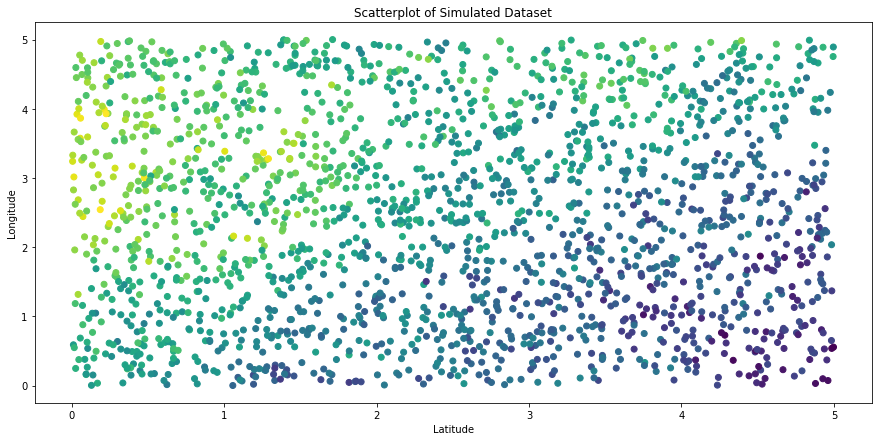

In [4]:
plt.scatter(x_all[:,0].numpy(), x_all[:,1].numpy(), c=y_all)
plt.title("Scatterplot of Simulated Dataset")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

Finally, we'll split our dataset into training and testing sets, and we will only use the training set in our blocking object.

In [5]:
idx = torch.randperm(sample_size)
train_idx = idx[0:int(0.8*sample_size)]
test_idx = idx[int(0.8*sample_size):sample_size]

x_train = x_all[train_idx,:]
y_train = y_all[train_idx]

x_test = x_all[test_idx,:]
y_test = y_all[test_idx]

### The K-Means Blocker

Our K-Means blocker can be found in the `vecchia` module of GPyTorch, so we will import it from there.

In [6]:
from gpytorch.vecchia import KMeansBlocker
print(KMeansBlocker.__doc__) # print class docstring for info on constructor parameters


    This blocker performs K-Means clustering on a given feature set, computes neighboring blocks, enables
    evaluating block membership for test points, and enables reordering of the blocks based on block centroids.

    :param data: Features to cluster via K-Means, typically an n x 2 tensor of spatial lat-long coordinates.
    :param n_blocks: Number of desired clusters. Note that this does not guarantee similarly-sized clusters.
    :param n_neighbors: Number of neighboring clusters per cluster.
    


Let's use this blocker to implement the NNGP model. In the NNGP model, we only consider singular observations and their neighbors, so want to divide our dataset into as many blocks as there are training observations. This ensures that each observation will belong to its own block. Let's also allow each observation to depend on its 5 nearest neighbors, where the neighbors are defined by Euclidean distance, subject to the ordering constraints discussed above.

In [7]:
kmeans_blocks = KMeansBlocker(x_train, n_blocks=len(x_train), n_neighbors=5)

We can use our built-in plotting method to visualize this object:

In [8]:
help(KMeansBlocker.plot)

Help on function plot in module gpytorch.vecchia._blocker:

plot(self, x: <built-in method tensor of type object at 0x1179b23f0>, y: <built-in method tensor of type object at 0x1179b23f0>, n_blocks: int = None, seed: int = 0)
    Useful visualization for this object and the ordering of the blocks, only implemented for 2D features.
    
    :param x: Spatial coordinates to plot. This must be the same tensor that was used to construct the blocks.
    :param y: Response values corresponding to each spatial coordinate in x.
    :param n_blocks: Number of blocks to sample for the plot.
    :param seed: RNG seed to change which blocks get randomly sampled.



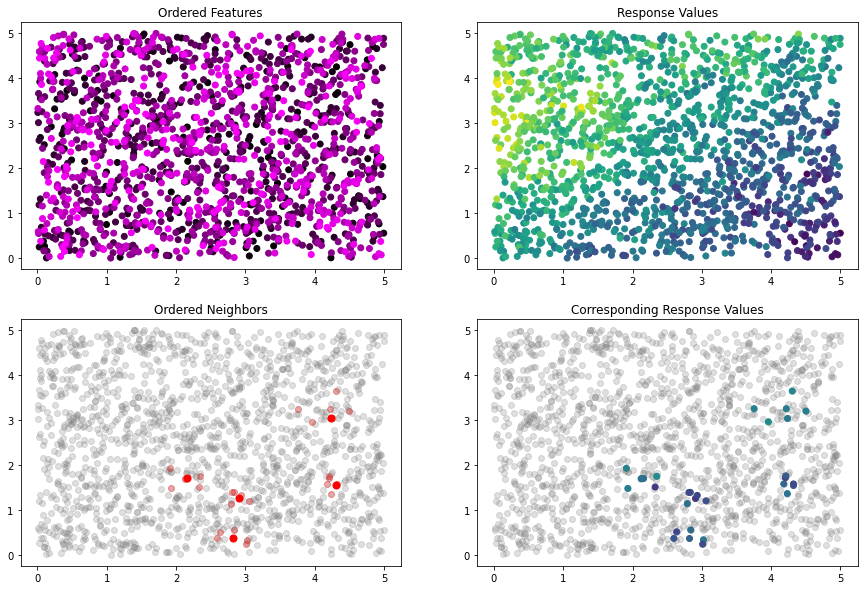

In [9]:
kmeans_blocks.plot(x_train, y_train, n_blocks=5, seed=1234567)

At this point, the data is ordered randomly, as the K-Means algorithm that we use does not order the clusters it creates. We can see this random ordering in the *Ordered Features* plot presented above, which colors each point by its index in the dataset. Since the ordering is random, this plot is homogenous.

The `kmeans_blocks` object contains all of the information about our ordered dataset and the neighbor relationships contained within. You can access this information with the `blocks` and `neighbors` properties. Let's look at the first 10 blocks with the `blocks` property.

In [10]:
help(KMeansBlocker.blocks)

Help on property:

    List of tensors where the ith element contains the indices of the training set points belonging to block i.



In [11]:
kmeans_blocks.blocks[:10]

[tensor([0]),
 tensor([1]),
 tensor([2]),
 tensor([3]),
 tensor([4]),
 tensor([5]),
 tensor([6]),
 tensor([7]),
 tensor([8]),
 tensor([9])]

From the description given above, we can interpret this as follows:
<br>
> The first block contains a single observation, which is located at index `0` in the training set.
<br>
> The second block contains a single observation, which is located at index `1` in the training set.
<br>
> ...
<br>
> The tenth block contains a single observation, which is located at index `9` in the training set.

So, suppose we want to get the x-values of the observation that belongs to the 8th block. We can do this as follows:

In [12]:
x_train[kmeans_blocks.blocks[7]]

tensor([[4.3157, 4.2567]])

Similarly, we can use the `neighbors` property to look at the *neighbors* of the first 10 blocks.

In [13]:
help(KMeansBlocker.neighbors)

Help on property:

    List of tensors, where the ith tensor contains the indices of the training set points belonging to the
    neighbor set of block i.



In [14]:
kmeans_blocks.neighbors[:10]

[tensor([]),
 tensor([0]),
 tensor([0, 1]),
 tensor([0, 1, 2]),
 tensor([3, 0, 1, 2]),
 tensor([2, 0, 3, 4, 1]),
 tensor([3, 4, 0, 1, 5]),
 tensor([1, 4, 6, 3, 0]),
 tensor([7, 1, 6, 4, 3]),
 tensor([7, 8, 6, 4, 1])]

Again, we can interpret this as follows:
<br>
> The first block has zero neighboring observations.
<br>
> The second block has one neighboring observation, which is located at index `0` in the training set.
<br>
> ...
<br>
> The tenth block has five neighboring observations, which are located at indices `7`,`8`,`6`,`4`, and `1` in the training set.

Suppose we want to get the x-values of the observations that neighbor the 8th block. We can do this as follows:

In [15]:
x_train[kmeans_blocks.neighbors[7]]

tensor([[4.9039, 2.2876],
        [3.0683, 2.4887],
        [2.1851, 3.7928],
        [2.4855, 2.6657],
        [2.1694, 2.1547]])

The y-values can be accessed in exactly the same way:

In [16]:
y_train[kmeans_blocks.neighbors[7]]

tensor([4.7161, 5.3252, 5.4674, 5.1377, 5.3944])

We can combine all of this to get a plot of the response values of the 8th block and the associated neighbors.

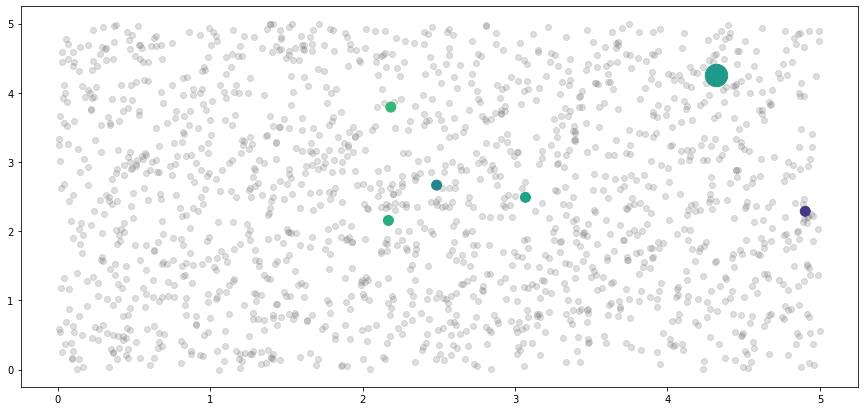

In [17]:
# create light grey plot to show whole dataset
plt.scatter(x_train[:,0].numpy(), x_train[:,1].numpy(), color="grey", alpha=0.25)

# plot the single observation in the 8th block
plt.scatter(x_train[kmeans_blocks.blocks[7]][:,0].numpy(),
            x_train[kmeans_blocks.blocks[7]][:,1].numpy(),
            c=y_train[kmeans_blocks.blocks[7]].numpy(),
            s=500, vmin=torch.min(y_train), vmax=torch.max(y_train))

# plot the neighbors of the 8th block
plt.scatter(x_train[kmeans_blocks.neighbors[7]][:,0].numpy(),
            x_train[kmeans_blocks.neighbors[7]][:,1].numpy(),
            c=y_train[kmeans_blocks.neighbors[7]].numpy(),
            s=100, vmin=torch.min(y_train), vmax=torch.max(y_train))

plt.show()

We can see that the single observation in the 8th block has five neighbors, just as we specified. However, these don't look like neighbors! This is because our blocks are unordered, and the observations that are allowed to be considered neighbors of the 8th block are essentially a random sample from our dataset. So, let's impose a new ordering structure.

## Ordering Strategies

As discussed in the introduction, there are many many different ways to order datasets to achieve better performance in Vecchia GP models. We've collected these different ways to order the data into an interface called `OrderingStrategies`, also located in GPyTorch's `vecchia` module.

In [18]:
from gpytorch.vecchia import OrderingStrategies

One of the most common ordering strategies is to order the data by the x or y coordinates. We have a `coordinate_ordering` method in `OrderingStrategies` that allows you to order by any column in your dataset. Ordering by the first column corresponds to an x-coordinate ordering, while ordering by the second column corresponds to a y-coordinate ordering.

The `KMeansBlocker` includes a `reorder` method that accepts a method from `OrderingStrategies` and reorders the blocks using the block centroids. Importantly, this is an **in place operation**. This means that the `reorder` method does not return a new `KMeansBlocker` instance with a new order, but reorders the blocks already stored in the `KMeansBlocker` instance. Let's see it all in action.

In [19]:
kmeans_blocks.reorder(OrderingStrategies.coordinate_ordering(0)) # order by first column, x-coordinate ordering

Now, we can use our `plot` method to see how the ordering has changed:

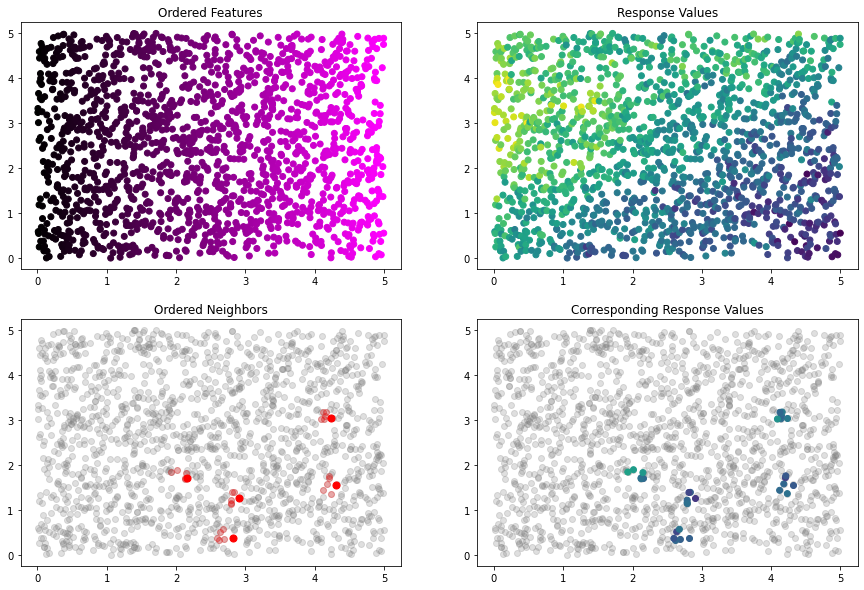

In [20]:
kmeans_blocks.plot(x_train, y_train, n_blocks=5, seed=1234567)

Our `blocks` and `neighbors` properties have changed to reflect the updated order.

In [21]:
kmeans_blocks.blocks[:10]

[tensor([354]),
 tensor([1222]),
 tensor([1223]),
 tensor([433]),
 tensor([623]),
 tensor([1002]),
 tensor([299]),
 tensor([319]),
 tensor([111]),
 tensor([1135])]

In [22]:
kmeans_blocks.neighbors[:10]

[tensor([]),
 tensor([354]),
 tensor([ 354, 1222]),
 tensor([ 354, 1222, 1223]),
 tensor([1222,  354,  433, 1223]),
 tensor([1223,  433,  354, 1222,  623]),
 tensor([ 433,  354, 1222,  623, 1223]),
 tensor([1223, 1002,  299,  433,  354]),
 tensor([1002, 1223,  319,  299,  433]),
 tensor([ 623, 1222,  354,  433,  299])]

We can also reuse the plot from earlier to view the 8th block and its associated neighbors.

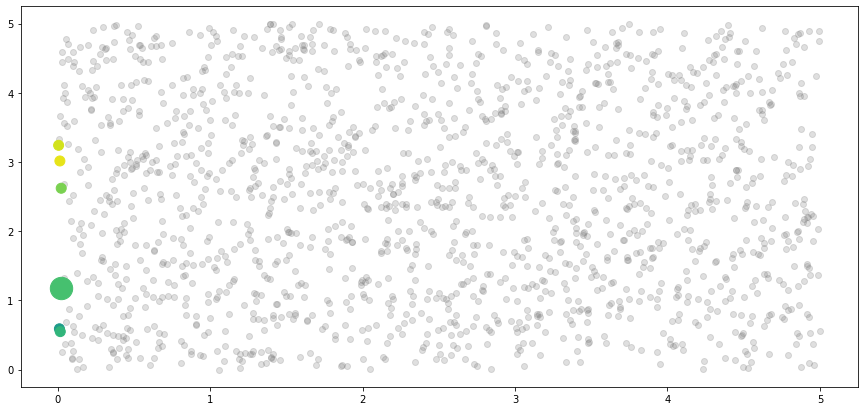

In [23]:
# create light grey plot to show whole dataset
plt.scatter(x_train[:,0].numpy(), x_train[:,1].numpy(), color="grey", alpha=0.25)

# plot the single observation in the 8th block
plt.scatter(x_train[kmeans_blocks.blocks[7]][:,0].numpy(),
            x_train[kmeans_blocks.blocks[7]][:,1].numpy(),
            c=y_train[kmeans_blocks.blocks[7]].numpy(),
            s=500, vmin=torch.min(y_train), vmax=torch.max(y_train))

# plot the neighbors of the 8th block
plt.scatter(x_train[kmeans_blocks.neighbors[7]][:,0].numpy(),
            x_train[kmeans_blocks.neighbors[7]][:,1].numpy(),
            c=y_train[kmeans_blocks.neighbors[7]].numpy(),
            s=100, vmin=torch.min(y_train), vmax=torch.max(y_train))

plt.show()